In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [3]:
path_base = '../mvTCR/data/Minervina'
path_out = f'{path_base}/01_annotated_data.h5ad'

## Merge Files

The data can be downloaded from https://zenodo.org/record/6232103#.YywJzBzP0uU

In [4]:
# transcriptome data
file_name = f'{path_base}/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(file_name, gex_only=False)

# TCR data
path_anno = f'{path_base}/filtered_contig_annotations.csv'
anno_tcr = ir.io.read_10x_vdj(path_anno)    
ir.pp.merge_with_ir(adata, anno_tcr)

adata.var_names_make_unique()

reading ../mvTCR/data/Minervina/filtered_feature_bc_matrix.h5
C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
 (0:00:01)


In [5]:
count_irs = sum([1 for x in adata.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata.obs)}')
print(f'With IR-Info: {count_irs}')

Total Count: 22959
With IR-Info: 18718


The authors filtered the data to exclude carrier cells, non T cells, and bad quality cells. We reduce the anndata object to their barcode list after filtering. This file can be found on the authors' github page. https://github.com/pogorely/COVID_vax_CD8

In [6]:
filtered_barcodes = pd.read_csv(f'{path_base}/cd8_only_dextr_rev_clean.tsv', sep='\t')
filtered_barcodes.index = filtered_barcodes['barcode']
filtered_barcodes.index.name = None
filtered_barcodes = filtered_barcodes[['batch', 'spike', 'sample_category', 'donor', 'epitope', 'donor_category']]
filtered_barcodes.head()

,batch,spike,sample_category,donor,epitope,donor_category
AAACCTGAGATCGGGT-6,batch_6,False,inf_vax,R23,A01_DTD,inf_after_1
AAACCTGAGCCTCGTG-4,batch_4,False,inf,R7,A01_TTD,post_inf
AAACCTGAGCTGTCTA-2,batch_2,True,vax,N2,A01_LTD,naive
AAACCTGAGGAATCGC-4,batch_4,NaN,NaN,NaN,A01_TTD,post_inf
AAACCTGAGGTGGGTT-4,batch_4,False,inf,R7,A01_TTD,post_inf


In [7]:
adata.obs = pd.concat([adata.obs, filtered_barcodes], axis=1)
adata.obs.head(5)

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir,batch,spike,sample_category,donor,epitope,donor_category
AAACCTGAGATCGGGT-1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGCATCACGTA-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,14335.0,NaN,...,NaN,TRBV27,NaN,True,batch_1,True,after_2,R29,A01_LTD,inf_after_2
AAACCTGGTGATGATA-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,8067.0,NaN,...,NaN,TRBV27,NaN,True,batch_1,True,after_2,R29,A01_LTD,inf_after_2
AAACCTGTCAACACAC-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,1407.0,NaN,...,NaN,TRBV30,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGAGCTGCAAG-1,True,True,False,[],TRAC,NaN,TRBC2,NaN,6765.0,NaN,...,NaN,TRBV4-2,NaN,True,batch_1,True,vax,N1,A24_QYI,naive


In [8]:
adata = adata[adata.obs.index.isin(filtered_barcodes.index)]
print(f'Valid T cell barcodes: {len(adata.obs)}')

selected_epitopes = [idx for idx, ct in adata.obs['epitope'].value_counts().items() if ct>=100]
adata = adata[adata.obs['epitope'].isin(selected_epitopes)]
print(f'Binding filtered: {len(adata)}')

adata = adata[~adata.obs['IR_VDJ_1_junction_aa'].isna()]
adata = adata[~adata.obs['IR_VJ_1_junction_aa'].isna()]
print(f'With full receptor: {len(adata)}')

adata = adata[adata.obs['IR_VDJ_2_junction_aa'].isna()]
adata = adata[adata.obs['IR_VJ_2_junction_aa'].isna()]
print(f'Without dual AIR: {len(adata)}')

adata = adata.copy()

Valid T cell barcodes: 12389
Binding filtered: 11488
With full receptor: 9884
Without dual AIR: 8618


## Normalization and variable genes


In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [10]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
print('Shape before: ', adata.shape)
adata = adata[:, adata.var['highly_variable']]
print('Shape after: ', adata.shape)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Shape before:  (8618, 36640)
Shape after:  (8618, 5000)


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


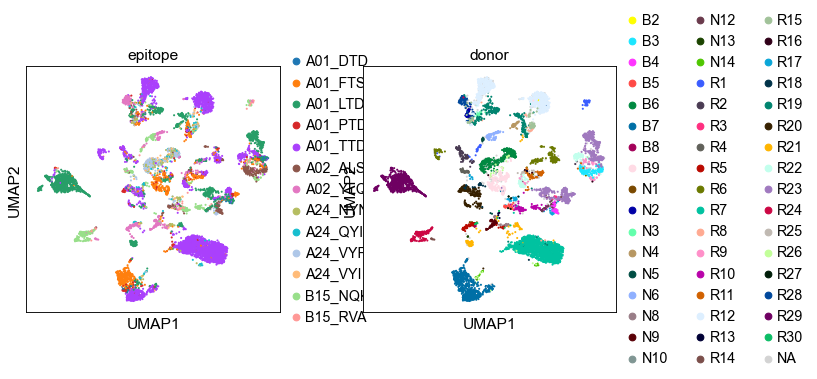

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['epitope', 'donor'])

## Clonotype annotation

In [12]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

3690


AAACCTGCATCACGTA-1    0
AAACCTGGTGATGATA-1    0
AAACGGGAGCTGCAAG-1    1
AAACGGGTCTTACCGC-1    0
AAAGATGAGGAACTGC-1    2
Name: clonotype, dtype: int64

## Embed Proteins

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [13]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_preprocessing as utils

In [14]:
import sys
sys.path.append('..')
from tcr_embedding.utils_preprocessing import encode_tcr

len_beta = adata.obs['IR_VDJ_1_junction_aa'].str.len().max()
len_alpha= adata.obs['IR_VJ_1_junction_aa'].str.len().max()
pad = max(len_beta, len_alpha)

encode_tcr(adata, 'IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa', pad)

## Donor conditional

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(adata.obs['donor'].to_numpy().reshape(-1, 1))
adata.obsm['donor'] = enc.transform(adata.obs['donor'].to_numpy().reshape(-1, 1))

## Save 

In [16]:
adata.obs['spike'] = adata.obs['spike'].astype(str)

adata.write_h5ad(path_out, compression='gzip')

In [18]:
adata.X.A.max()

9.106862